添加引用

In [1]:
import utils
import params
import cv2
import matplotlib.pyplot as plt
import pickle
import numpy as np


Using TensorFlow backend.


从Tesla数据集的视频中，得到训练图片。从数据集的车辆转向记录中读取转向数据，将转向数据和训练图片做一一对应，得到训练数据集。

In [2]:
def img_pre_process(img, resize_w, resize_h):
    """
    Processes the image and returns it
    :param img: The image to be processed
    :return: Returns the processed image
    """
    ## Chop off 1/3 from the top and cut bottom 150px(which contains the head of car)
    shape = img.shape
#    print("shape  ", shape)
    img = img[int(shape[0]/3):shape[0]-150, 0:shape[1]]
    ## Resize the image
    img = cv2.resize(img, (resize_w, resize_h), interpolation=cv2.INTER_CUBIC)
    ## Return the image sized as a 4D array
  #  plt.imshow(img)
  #  plt.show()
  #  return img
    return np.resize(img, (resize_h, resize_w, params.FLAGS.img_c))


In [3]:
from sklearn.model_selection import train_test_split

#加载epoch1到epoch9的所有视频的图片到img_list中，加载epoch1到epoch9的所有转向数据到steer_list，
def loadVideoAndResize(resize_w, resize_h):
    for epoch_id in range(1,11):    
        vid_path = utils.join_dir(params.data_dir, 'epoch{:0>2}_front.mkv').format(epoch_id)
        steer_path = utils.join_dir(params.data_dir, 'epoch{:0>2}_steering.csv').format(epoch_id)
        steer_data = utils.fetch_csv_data(steer_path)
    
        steer_list = steer_data['wheel'] 
    
        frame_count = utils.frame_count(vid_path)
        cap = cv2.VideoCapture(vid_path)
        img_list = []
    
        for frame_id in range(frame_count):
            ret, img = cap.read()       
            img_resized = img_pre_process(img, resize_w, resize_h)
            img_list.append(img_resized)
        
            if frame_id == frame_count - 1 and epoch_id == 1:
                print("img pre shape {}".format(img.shape))
                print("img after shape {}".format(img_resized.shape))
                plt.imshow(img)
                plt.show()
                plt.imshow(img_resized)
                plt.show()
    
   
    #把训练集存到本地
        train_add = 'epoch{:0>2}_{}_{}_preprocess_train.p'.format(epoch_id, resize_w,resize_h)
     #   val_add = 'epoch{:0>2}_{}_{}_preprocess_val.p'.format(epoch_id, resize_w,resize_h)
        pickle.dump((img_list, steer_list), open(train_add, 'wb'))
     #   pickle.dump((img_list_val, steer_list_val), open(val_add, 'wb'))





/home/ubuntu/tesla/for_tesla/epochs/epoch01_front.mkv
img pre shape (720, 1280, 3)
img after shape (224, 224, 3)


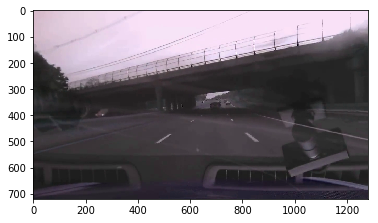

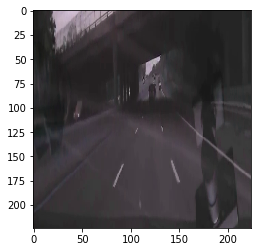

/home/ubuntu/tesla/for_tesla/epochs/epoch02_front.mkv
/home/ubuntu/tesla/for_tesla/epochs/epoch03_front.mkv
/home/ubuntu/tesla/for_tesla/epochs/epoch04_front.mkv
/home/ubuntu/tesla/for_tesla/epochs/epoch05_front.mkv
/home/ubuntu/tesla/for_tesla/epochs/epoch06_front.mkv
/home/ubuntu/tesla/for_tesla/epochs/epoch07_front.mkv
/home/ubuntu/tesla/for_tesla/epochs/epoch08_front.mkv
/home/ubuntu/tesla/for_tesla/epochs/epoch09_front.mkv
/home/ubuntu/tesla/for_tesla/epochs/epoch10_front.mkv


In [109]:
#将视频解码成预训练网络需要的图片尺寸的图片 
loadVideoAndResize(224, 224)

加载数据

In [4]:

def load_preprocess_training_batch(batch_id, resize_w, resize_h):
    filename = 'epoch{:0>2}_{}_{}_preprocess_train.p'.format(batch_id, resize_w, resize_h)
    img, steer = pickle.load(open(filename, mode='rb'))

    return img, steer
def load_preprocess_validating_batch(batch_id, resize_w, resize_h):
    filename = 'epoch{:0>2}_{}_{}_preprocess_val.p'.format(batch_id, resize_w, resize_h)
    img, steer = pickle.load(open(filename, mode='rb'))

    return img, steer

In [5]:
from keras.models import Sequential, Model
from keras.layers import Dense
from keras.layers import Dense, Dropout, Activation, Flatten, Lambda, ELU
from keras.layers import Convolution2D, MaxPooling2D,Conv2D
from keras import optimizers
from keras.wrappers.scikit_learn import KerasRegressor
from keras.preprocessing.image import ImageDataGenerator
seed = 10
#0213 为interception
#0312 为其它
model_trans = (0, 2, 1, 3)

In [6]:
#这里将输出的转向角度处理成间隔为0.5的数值，这是因为训练数据和测试数据的转向角度都是这样的数据
def nor_output(pre_y):
    pre = pre_y.reshape(1, -1)[0]
    for i, x in enumerate(pre):
        pre[i] = round(x, 4)

    for i,x in enumerate(pre):
        if x > 0:
            if (x-math.floor(x))>=0.75:
                pre[i] = int(x) + 1.0
            elif (x-math.floor(x))>=0.25:
                pre[i] = (int(x) + 0.5)
            else:
                pre[i] = int(x)
        else:
            if (x-int(x))<=-0.75:
                pre[i] = int(x) - 1.0
            elif (x-int(x))<=-0.25:
                pre[i] = (int(x) - 0.5)
            else:
                pre[i] = int(x)
    return pre

In [40]:
#简单模型
def simple_model_1(time_len=1):
    ch, row, col = 3, 64, 64  # camera format
    model = Sequential()
    model.add(Lambda(lambda x: x/127.5 - 1.,
  #  model.add(Lambda(lambda x: x,
            input_shape=( row, col, ch),
            output_shape=( row, col,ch)))
    model.add(Convolution2D(32, 5, 5, subsample=(2, 2), border_mode="same"))
    model.add(ELU())
    model.add(Convolution2D(64, 5, 5, subsample=(2, 2), border_mode="same"))
    model.add(ELU())
    model.add(Convolution2D(128, 5, 5, subsample=(2, 2), border_mode="same"))
    
    model.add(Flatten())
    model.add(Dropout(.5))
    model.add(ELU())
    model.add(Dense(512))
    model.add(Dropout(.5))
    model.add(ELU())
    model.add(Dense(1))
#  model.add(Lambda(nor_output_1))
    sgd = optimizers.SGD(lr=0.00003, momentum=0.9, nesterov=True)
    model.compile(loss='mean_squared_error', optimizer=sgd)

      

    return model

In [70]:
from keras.layers import Input, Dense, Flatten, Convolution2D, MaxPooling2D, Dropout
def tesla_model(time_len=1):
    ch, height, width = 3, 66, 200  # camera format
    inp = Input(shape=(width,height,  ch)) 
    lam = Lambda(lambda x: x/127.5 - 1.,
            input_shape=( width, height, ch),
            output_shape=(width,height,  ch))(inp)
    conv_0 = Convolution2D(3, (5, 5),subsample=(2, 2),  padding='same', activation='relu', kernel_initializer='he_normal')(lam)
    conv_0 = BatchNormalization()(conv_0)
    conv_1 = Convolution2D(24, (5, 5),subsample=(2, 2),  padding='same', activation='relu', kernel_initializer='he_normal')(conv_0)
    conv_1 = BatchNormalization()(conv_1)
    conv_2 = Convolution2D(36, (5, 5),subsample=(2, 2),  padding='same', activation='relu', kernel_initializer='he_normal')(conv_1)
    conv_2 = BatchNormalization()(conv_2)#
    
 #   conv_2_5 = Convolution2D(96, (1, 1), padding='same', activation='relu', kernel_initializer='he_normal')(conv_2)
 #   conv_2_5 = BatchNormalization()(conv_2_5)
    conv_3 = Convolution2D(64, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal')(conv_2)
    conv_3 = BatchNormalization()(conv_3)
    conv_4 = Convolution2D(72, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal')(conv_3)
    conv_4 = BatchNormalization()(conv_4)
    
  #  conv_4_1 = Convolution2D(72, (1, 1), padding='same', activation='relu', kernel_initializer='he_normal')(conv_4)
  #  conv_4_1 = BatchNormalization()(conv_4_1)
    
    conv_5 = Convolution2D(84, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal')(conv_4)
    conv_5 = BatchNormalization()(conv_5)
    conv_5_1 = Convolution2D(184, (1, 1), padding='same', activation='relu', kernel_initializer='he_normal')(conv_5)
    conv_5_1 = BatchNormalization()(conv_5_1)
    
    conv_6 = Convolution2D(96, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal')(conv_5_1)
    conv_6 = BatchNormalization()(conv_6)
    
    conv_6_1 = Convolution2D(112, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal')(conv_6)
    conv_6_1 = BatchNormalization()(conv_6_1)
    
  #  conv_7 = Convolution2D(124, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal')(conv_6_1)
  #  conv_7 = BatchNormalization()(conv_7)
    
    conv_8_1 = Convolution2D(212, (1, 1), padding='same', activation='relu', kernel_initializer='he_normal')(conv_6_1)
    conv_8_1 = BatchNormalization()(conv_8_1)
    
    conv_9 = Convolution2D(136, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal')(conv_8_1)
    conv_9 = BatchNormalization()(conv_9)
    conv_9_1 = Convolution2D(212, (1, 1), padding='same', activation='relu', kernel_initializer='he_normal')(conv_9)
    conv_9_1 = BatchNormalization()(conv_9_1)
    
    flat = Flatten()(conv_9_1)
 #   
    hidden1 = Dense(1164, activation='relu', kernel_initializer='glorot_normal',
                         kernel_regularizer=regularizers.l2(0.00002),
                        bias_regularizer=regularizers.l2(0.00002),
                      #  activity_regularizer=regularizers.l1(0.003),
                   )(flat)
 #   drop1 = Dropout(.5)(hidden1)
 #   hidden1 = BatchNormalization()(hidden1)
    hidden2 = Dense(100, activation='relu', kernel_initializer='glorot_normal')(hidden1)
    
 #   hidden2 = BatchNormalization()(hidden2)
 #   drop2 = Dropout(.9)(hidden2)
    hidden3 = Dense(50, activation='relu', kernel_initializer='glorot_normal')(hidden2)
       
 #   hidden3 = BatchNormalization()(hidden3)
 #   drop3 = Dropout(.5)(hidden3)
    hidden4 = Dense(10, activation='relu',
                   #     kernel_regularizer=regularizers.l2(0.005),
                   #     bias_regularizer=regularizers.l2(0.003),
                      #  activity_regularizer=regularizers.l1(0.003),
                        kernel_initializer='glorot_normal')(hidden3)
 #   drop4 = Dropout(.5)(hidden4)
    out = Dense(1, activation='linear', kernel_initializer='glorot_normal')(hidden4) 
    

    model = Model(inputs=inp, outputs=out) 
    sgd = optimizers.SGD(lr=0.00005, momentum=0.9, nesterov=True)
    model.compile(loss='mean_squared_error', optimizer=sgd)

      

    return model

In [15]:
#inceptionV3_model 算法
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
def inceptionV3_model(time_len=1):
# create the base pre-trained model 299 * 299
    base_model = InceptionV3(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation = 'relu',
                        kernel_regularizer=regularizers.l2(0.1),
                        bias_regularizer=regularizers.l2(0.01),
                      #  activity_regularizer=regularizers.l1(0.003),
                        kernel_initializer='glorot_normal')(x)
    x = Dropout(.5)(x)
#    x = BatchNormalization()(x)
    predictions = Dense(1)(x)

# this is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
    for layer in base_model.layers:
        layer.trainable = False

    for i, layer in enumerate(base_model.layers):
        print(i, layer.name)

    for layer in model.layers[:289]:
        layer.trainable = True
    for layer in model.layers[289:]:
        layer.trainable = True

    sgd = optimizers.SGD(lr=0.00001, momentum=0.9, nesterov=True)
    model.compile(loss='mean_squared_error', optimizer=sgd)

    return model

In [36]:
batch_size = 64
epoches = 20
vgg_start_train_net = 0
vgg_r_w = 0
vgg_r_b = 0
vgg_lr = 0.00005

In [21]:
from keras import applications
from keras.applications.vgg19 import VGG19
import numpy as np
from keras import regularizers
from keras.layers.normalization import BatchNormalization

def vgg19_model(time_len=1):
    #224 * 224
    img_rows, img_cols, img_channel = 224, 224, 3

    base_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, img_channel))

    add_model = Sequential()
    add_model.add(Flatten(input_shape=base_model.output_shape[1:]))
    den = Dense(512, activation = 'relu',
                        kernel_regularizer=regularizers.l2(vgg_r_w),
                        bias_regularizer=regularizers.l2(vgg_r_b),
                      #  activity_regularizer=regularizers.l1(0.003),
                        kernel_initializer='glorot_normal')
  #  den = BatchNormalization()(den)
    add_model.add(den)
  #  add_model.add(Dropout(.5))
    add_model.add(Dense(1, activation='linear'))

    model = Model(inputs=base_model.input, outputs=add_model(base_model.output))
    
    for layer in base_model.layers:
        layer.trainable = False
    
    
    for i, layer in enumerate(base_model.layers):
        print(i, layer.name)
        
    for layer in model.layers[:vgg_start_train_net]:
        layer.trainable = False
    for layer in model.layers[vgg_start_train_net:]:
        layer.trainable = True
        
    sgd = optimizers.SGD(lr=vgg_lr)
    model.compile(loss='mse', optimizer=sgd)
    return model

In [10]:
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np

def restNet_model(time_len=1):
    #224 * 224
    base_model = ResNet50(weights='imagenet', include_top=False)

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation = 'relu',
                        kernel_regularizer=regularizers.l2(res_r_w),
                        bias_regularizer=regularizers.l2(res_r_b),
                      #  activity_regularizer=regularizers.l1(0.003),
                        kernel_initializer='glorot_normal')(x)
 #   x = Dropout(.5)(x)
#    x = BatchNormalization()(x)
    predictions = Dense(1)(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    for layer in base_model.layers:
        layer.trainable = False
    
    
    for i, layer in enumerate(base_model.layers):
        print(i, layer.name)
        
    for layer in model.layers[:res_start_train_net]:
        layer.trainable = False
    for layer in model.layers[res_start_train_net:]:
        layer.trainable = True
        
    sgd = optimizers.SGD(lr=res_lr, momentum=0.9, nesterov=True)
    model.compile(loss='mean_squared_error', optimizer=sgd)
    return model

In [41]:
#训练模型
from sklearn.metrics import mean_squared_error, r2_score
from keras.applications.vgg19 import preprocess_input
#from keras.applications.resnet50 import preprocess_input


import matplotlib.pyplot as plt
import math
from decimal import Decimal
def train_model(video_list, model_func, resize_w, resize_h, ifSave = False, test_img=None, test_y=None):
    model = model_func()
    
    val_acc = []
    test_acc = []
    train_acc = []
    
    datagen_train = ImageDataGenerator(
                 #   featurewise_center=True,
                 #   preprocessing_function=preprocess_input,
                 #   featurewise_std_normalization=True                  
                    )
    datagen_test = ImageDataGenerator(
                #    featurewise_center=True,
                #     preprocessing_function=preprocess_input,
                #    featurewise_std_normalization=True                  
                    )
    datagen_val = ImageDataGenerator(
                 #   featurewise_center=True,
                 #    preprocessing_function=preprocess_input,
                 #   featurewise_std_normalization=True                  
                    )
    
    test_img, test_y = load_preprocess_training_batch(10, res_w, res_h)   
    test_img = np.array(test_img).transpose(model_trans)
    datagen_test.fit(test_img)
    for x_batch, y_batch in datagen_test.flow(test_img, test_y, batch_size=len(test_y)):
        test_img = x_batch
        test_y = y_batch
        break
        
    x_val, y_val = load_preprocess_training_batch(7, res_w, res_h)   
    x_val = np.array(x_val).transpose(model_trans)
    datagen_val.fit(x_val)
    for x_batch, y_batch in datagen_val.flow(x_val, y_val, batch_size=len(y_val)):
        
        x_val = x_batch
        y_val = y_batch
        break
    for epoch_idx in range(0, epoches):
        
     #   x_val = np.array([])
     #   y_val = []
        x_train_all = np.array([])
        y_train_all = []
        for video_idx in [1,2,3,4,5,6,8,9]:
            x_train, y_train = load_preprocess_training_batch(video_idx, resize_w, resize_h)
            x_train = np.array(x_train).transpose(model_trans)
            
         #   print(model_trans)
            #随机打乱数据，取10%的训练数据做验证集
        #    img_list_train, img_list_val, steer_list_train, steer_list_val = train_test_split(x_train, np.array(y_train), test_size=0.1, random_state=10) 
            
            datagen_train.fit(x_train)
            model.fit_generator(datagen_train.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=int (len(y_train) /batch_size) +1 , epochs=1,shuffle=True)
            
            if video_idx == 1:
                if x_train_all.shape == np.array([]).shape:
                    x_train_all = x_train
                    y_train_all = list(y_train)
                else:
                    x_train_all = np.vstack((x_train_all, x_train))
                    y_train_all.extend(list(y_train))
        
        
     #   for x_batch, y_batch in datagen_val.flow(x_val, y_val, batch_size=len(y_val)):
    #        x_val = x_batch
    #        y_val = y_batch
    #        break
        train_acc.append(test_model(model, x_train_all, y_train_all, ifShow = False, note = "train"))
        val_acc.append(test_model(model, x_val, y_val, ifShow = False, note = "val"))
      #  test_acc.append(test_model(model, test_img, test_y, ifShow = False, note = "test"))
    
    
    plt.plot(train_acc, color='#FF00FF', label = 'train_accuracy')
    plt.plot(val_acc,color='b', label='val_accuracy')
  #  plt.plot(test_acc, color='g', label='test_accuracy')
    plt.legend()
    plt.show()
    if ifSave == True:
        utils.save_model(model)
    return model, test_img, test_y

In [23]:
#测试模型
def test_model(model, img_list_val, y_val, ifShow=False, note=''):
    pre = model.predict(img_list_val)
    pre = nor_output(pre)
  #  print (pre)
    score = r2_score(y_val, pre)
    print("%s score: %.2f " % (note,score))
    

    if type(y_val) != np.array:
        y_val = np.array(y_val)
    y_val = y_val.reshape(len(list(y_val)), 1)    
    y_val = y_val.reshape(1, -1)[0]
    x = np.arange(1, len(y_val) + 1)
    y = y_val  - pre ;

    if ifShow==True:
        plt.plot(x, abs(y) , marker = '.', color = 'b', label = 'steer bias',linewidth=0.1)
        plt.legend()
        plt.show()
    return score

In [37]:
res_w = 200
res_h = 66


训练全部视频

In [ ]:
增加rw,rb,加conv_9, conv9_1

In [ ]:
model_all,test_img, test_y = train_model(range(1, 2),  tesla_model, res_w, res_h, ifSave = True)
test_model(model_all, test_img, test_y, ifShow = True, note = "test")

/home/ubuntu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(3, (5, 5), padding="same", activation="relu", kernel_initializer="he_normal", strides=(2, 2))`
  
/home/ubuntu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), padding="same", activation="relu", kernel_initializer="he_normal", strides=(2, 2))`
  # Remove the CWD from sys.path while we load stuff.
/home/ubuntu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), padding="same", activation="relu", kernel_initializer="he_normal", strides=(2, 2))`
  if sys.path[0] == '':


Epoch 1/1


In [ ]:
去掉conv6_1,去掉rw,rb,drop

/home/ubuntu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(3, (5, 5), padding="same", activation="relu", kernel_initializer="he_normal", strides=(2, 2))`
  
/home/ubuntu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), padding="same", activation="relu", kernel_initializer="he_normal", strides=(2, 2))`
  # Remove the CWD from sys.path while we load stuff.
/home/ubuntu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), padding="same", activation="relu", kernel_initializer="he_normal", strides=(2, 2))`
  if sys.path[0] == '':


Epoch 1/1
24/24 [==============================] - 8s 338ms/step - loss: 11.2710
Epoch 1/1
61/61 [==============================] - 8s 132ms/step - loss: 4.0535
Epoch 1/1
43/43 [==============================] - 6s 130ms/step - loss: 6.1995
Epoch 1/1
43/43 [==============================] - 6s 130ms/step - loss: 29.7983
Epoch 1/1
43/43 [==============================] - 6s 130ms/step - loss: 6.2869
Epoch 1/1
43/43 [==============================] - 6s 130ms/step - loss: 8.7873
Epoch 1/1
43/43 [==============================] - 6s 130ms/step - loss: 4.9813
Epoch 1/1
43/43 [==============================] - 6s 130ms/step - loss: 1.2390
train score: -0.09 
val score: 0.17 
Epoch 1/1
24/24 [==============================] - 3s 130ms/step - loss: 3.9898
Epoch 1/1
61/61 [==============================] - 8s 131ms/step - loss: 1.1277
Epoch 1/1
43/43 [==============================] - 6s 130ms/step - loss: 2.8603
Epoch 1/1
43/43 [==============================] - 6s 130ms/step - loss: 8.4007
E

Epoch 1/1
61/61 [==============================] - 8s 132ms/step - loss: 0.0410
Epoch 1/1
43/43 [==============================] - 6s 130ms/step - loss: 0.0935
Epoch 1/1
43/43 [==============================] - 6s 130ms/step - loss: 0.1260
Epoch 1/1
43/43 [==============================] - 6s 130ms/step - loss: 0.1092
Epoch 1/1
43/43 [==============================] - 6s 130ms/step - loss: 0.1486
Epoch 1/1
43/43 [==============================] - 6s 130ms/step - loss: 0.1195
Epoch 1/1
43/43 [==============================] - 6s 130ms/step - loss: 0.0299
train score: 0.87 
val score: 0.34 
Epoch 1/1
24/24 [==============================] - 3s 129ms/step - loss: 0.0479
Epoch 1/1
61/61 [==============================] - 8s 131ms/step - loss: 0.0369
Epoch 1/1
43/43 [==============================] - 6s 130ms/step - loss: 0.0938
Epoch 1/1
43/43 [==============================] - 6s 130ms/step - loss: 0.1312
Epoch 1/1
43/43 [==============================] - 6s 130ms/step - loss: 0.0993
Epoc

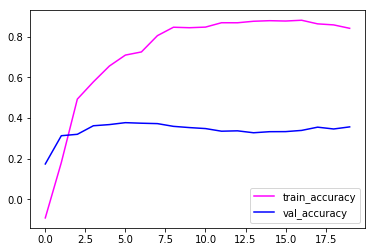

Model saved
test score: 0.39 


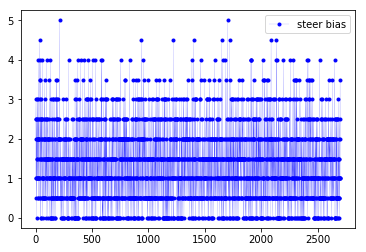

0.39182016833662092

In [56]:
model_all,test_img, test_y = train_model(range(1, 2),  tesla_model, res_w, res_h, ifSave = True)
test_model(model_all, test_img, test_y, ifShow = True, note = "test")

In [ ]:
去掉r_w, r_b

/home/ubuntu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(3, (5, 5), padding="same", activation="relu", kernel_initializer="he_normal", strides=(2, 2))`
  
/home/ubuntu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), padding="same", activation="relu", kernel_initializer="he_normal", strides=(2, 2))`
  # Remove the CWD from sys.path while we load stuff.
/home/ubuntu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), padding="same", activation="relu", kernel_initializer="he_normal", strides=(2, 2))`
  if sys.path[0] == '':
/home/ubuntu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(84, (5, 5), padding="same", activation="relu", kernel_initial

Epoch 1/1
24/24 [==============================] - 6s 269ms/step - loss: 12.6666
Epoch 1/1
61/61 [==============================] - 6s 98ms/step - loss: 4.2726
Epoch 1/1
43/43 [==============================] - 4s 97ms/step - loss: 7.5703
Epoch 1/1
43/43 [==============================] - 4s 98ms/step - loss: 64.3735
Epoch 1/1
43/43 [==============================] - 4s 98ms/step - loss: 7.8670
Epoch 1/1
43/43 [==============================] - 4s 98ms/step - loss: 21.1631
Epoch 1/1
43/43 [==============================] - 4s 98ms/step - loss: 10.3202
Epoch 1/1
43/43 [==============================] - 4s 98ms/step - loss: 2.0588
train score: -0.17 
val score: 0.03 
Epoch 1/1
24/24 [==============================] - 2s 97ms/step - loss: 5.8260
Epoch 1/1
61/61 [==============================] - 6s 99ms/step - loss: 1.8023
Epoch 1/1
43/43 [==============================] - 4s 98ms/step - loss: 4.1150
Epoch 1/1
43/43 [==============================] - 4s 98ms/step - loss: 13.9893
Epoch 1/1

Epoch 1/1
43/43 [==============================] - 4s 98ms/step - loss: 0.3723
Epoch 1/1
43/43 [==============================] - 4s 98ms/step - loss: 0.7874
Epoch 1/1
43/43 [==============================] - 4s 98ms/step - loss: 0.5094
Epoch 1/1
43/43 [==============================] - 4s 98ms/step - loss: 0.5553
Epoch 1/1
43/43 [==============================] - 4s 98ms/step - loss: 0.4496
Epoch 1/1
43/43 [==============================] - 4s 97ms/step - loss: 0.2122
train score: 0.49 
val score: 0.33 
Epoch 1/1
24/24 [==============================] - 2s 97ms/step - loss: 0.2874
Epoch 1/1
61/61 [==============================] - 6s 99ms/step - loss: 0.2068
Epoch 1/1
43/43 [==============================] - 4s 98ms/step - loss: 0.3739
Epoch 1/1
43/43 [==============================] - 4s 98ms/step - loss: 0.7479
Epoch 1/1
43/43 [==============================] - 4s 98ms/step - loss: 0.4744
Epoch 1/1
43/43 [==============================] - 4s 99ms/step - loss: 0.4859
Epoch 1/1
43/43 

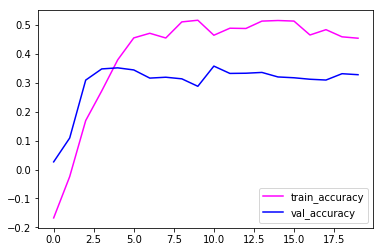

Model saved
test score: 0.50 


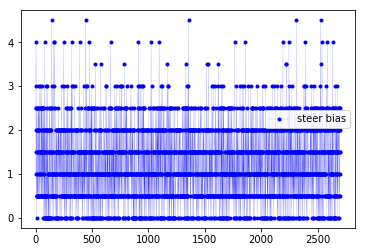

0.50075156118640352

In [44]:
model_all,test_img, test_y = train_model(range(1, 2),  tesla_model, res_w, res_h, ifSave = True)
test_model(model_all, test_img, test_y, ifShow = True, note = "test")

In [ ]:
修改conv7_1 为3*3

/home/ubuntu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(3, (5, 5), padding="same", activation="relu", kernel_initializer="he_normal", strides=(2, 2))`
  
/home/ubuntu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), padding="same", activation="relu", kernel_initializer="he_normal", strides=(2, 2))`
  # Remove the CWD from sys.path while we load stuff.
/home/ubuntu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), padding="same", activation="relu", kernel_initializer="he_normal", strides=(2, 2))`
  if sys.path[0] == '':
/home/ubuntu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(84, (5, 5), padding="same", activation="relu", kernel_initial

Epoch 1/1
24/24 [==============================] - 9s 378ms/step - loss: 11.6446
Epoch 1/1
61/61 [==============================] - 5s 75ms/step - loss: 3.5808
Epoch 1/1
43/43 [==============================] - 3s 73ms/step - loss: 7.0083
Epoch 1/1
43/43 [==============================] - 3s 74ms/step - loss: 41.2679
Epoch 1/1
43/43 [==============================] - 3s 73ms/step - loss: 9.2949
Epoch 1/1
43/43 [==============================] - 3s 74ms/step - loss: 16.2893
Epoch 1/1
43/43 [==============================] - 3s 73ms/step - loss: 7.3066
Epoch 1/1
43/43 [==============================] - 3s 74ms/step - loss: 1.9466
train score: 0.06 
val score: -0.00 
Epoch 1/1
24/24 [==============================] - 2s 73ms/step - loss: 5.8082
Epoch 1/1
61/61 [==============================] - 5s 75ms/step - loss: 1.6531
Epoch 1/1
43/43 [==============================] - 3s 73ms/step - loss: 4.4094
Epoch 1/1
43/43 [==============================] - 3s 74ms/step - loss: 13.0405
Epoch 1/1


43/43 [==============================] - 3s 73ms/step - loss: 0.4003
Epoch 1/1
43/43 [==============================] - 3s 74ms/step - loss: 0.4723
Epoch 1/1
43/43 [==============================] - 3s 74ms/step - loss: 0.3893
Epoch 1/1
43/43 [==============================] - 3s 75ms/step - loss: 0.1759
train score: 0.59 
val score: 0.34 
Epoch 1/1
24/24 [==============================] - 2s 74ms/step - loss: 0.2500
Epoch 1/1
61/61 [==============================] - 5s 75ms/step - loss: 0.1726
Epoch 1/1
43/43 [==============================] - 3s 74ms/step - loss: 0.2917
Epoch 1/1
43/43 [==============================] - 3s 74ms/step - loss: 0.6838
Epoch 1/1
43/43 [==============================] - 3s 74ms/step - loss: 0.3874
Epoch 1/1
43/43 [==============================] - 3s 74ms/step - loss: 0.4640
Epoch 1/1
43/43 [==============================] - 3s 74ms/step - loss: 0.3923
Epoch 1/1
43/43 [==============================] - 3s 74ms/step - loss: 0.1730
train score: 0.58 
val sco

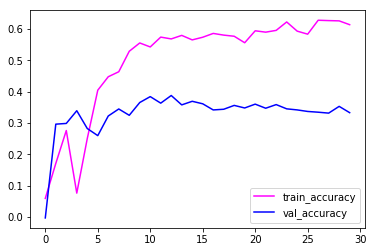

Model saved
test score: 0.55 


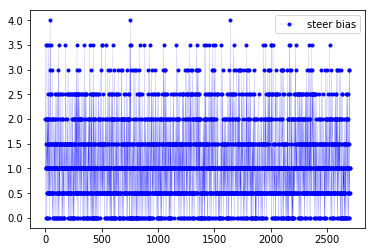

0.55278429294366638

In [102]:
model_all,test_img, test_y = train_model(range(1, 2),  tesla_model, res_w, res_h, ifSave = True)
test_model(model_all, test_img, test_y, ifShow = True, note = "test")

In [ ]:
增加conv7,conv7_1,conv8, conv8_1

/home/ubuntu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(3, (5, 5), padding="same", activation="relu", kernel_initializer="he_normal", strides=(2, 2))`
  
/home/ubuntu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), padding="same", activation="relu", kernel_initializer="he_normal", strides=(2, 2))`
  # Remove the CWD from sys.path while we load stuff.
/home/ubuntu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), padding="same", activation="relu", kernel_initializer="he_normal", strides=(2, 2))`
  if sys.path[0] == '':
/home/ubuntu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(84, (5, 5), padding="same", activation="relu", kernel_initial

Epoch 1/1
24/24 [==============================] - 8s 338ms/step - loss: 9.8898
Epoch 1/1
61/61 [==============================] - 5s 81ms/step - loss: 3.0668
Epoch 1/1
43/43 [==============================] - 3s 80ms/step - loss: 6.9085
Epoch 1/1
43/43 [==============================] - 3s 79ms/step - loss: 42.7465
Epoch 1/1
43/43 [==============================] - 3s 79ms/step - loss: 7.3982
Epoch 1/1
43/43 [==============================] - 3s 80ms/step - loss: 16.8428
Epoch 1/1
43/43 [==============================] - 3s 80ms/step - loss: 13.0792
Epoch 1/1
43/43 [==============================] - 3s 79ms/step - loss: 1.6050
train score: -0.18 
val score: -0.15 
Epoch 1/1
24/24 [==============================] - 2s 79ms/step - loss: 4.8033
Epoch 1/1
61/61 [==============================] - 5s 81ms/step - loss: 1.7049
Epoch 1/1
43/43 [==============================] - 3s 79ms/step - loss: 5.5712
Epoch 1/1
43/43 [==============================] - 3s 79ms/step - loss: 15.9790
Epoch 1/1

43/43 [==============================] - 3s 80ms/step - loss: 0.4279
Epoch 1/1
43/43 [==============================] - 3s 80ms/step - loss: 0.5014: 1
Epoch 1/1
43/43 [==============================] - 3s 80ms/step - loss: 0.4510
Epoch 1/1
43/43 [==============================] - 3s 80ms/step - loss: 0.1896
train score: 0.77 
val score: 0.17 
Epoch 1/1
24/24 [==============================] - 2s 79ms/step - loss: 0.2818
Epoch 1/1
61/61 [==============================] - 5s 81ms/step - loss: 0.1817
Epoch 1/1
43/43 [==============================] - 3s 80ms/step - loss: 0.3289
Epoch 1/1
43/43 [==============================] - 3s 79ms/step - loss: 0.7029
Epoch 1/1
43/43 [==============================] - 3s 80ms/step - loss: 0.4521
Epoch 1/1
43/43 [==============================] - 3s 80ms/step - loss: 0.5009
Epoch 1/1
43/43 [==============================] - 3s 79ms/step - loss: 0.4320
Epoch 1/1
43/43 [==============================] - 3s 79ms/step - loss: 0.1905
train score: 0.77 
val 

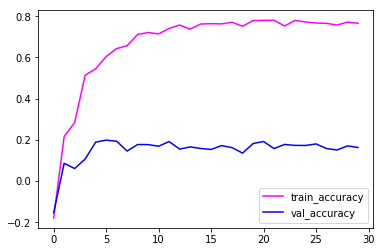

Model saved
test score: 0.55 


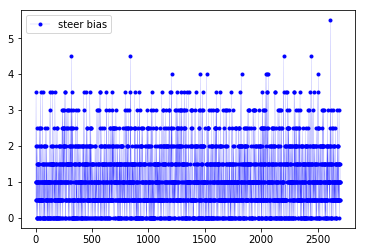

0.5538474371681763

In [91]:
model_all,test_img, test_y = train_model(range(1, 2),  tesla_model, res_w, res_h, ifSave = True)
test_model(model_all, test_img, test_y, ifShow = True, note = "test")

In [ ]:
conv5_1 1*1 con5_1 1*1都加回来

/home/ubuntu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(3, (5, 5), padding="same", activation="relu", kernel_initializer="he_normal", strides=(2, 2))`
  
/home/ubuntu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), padding="same", activation="relu", kernel_initializer="he_normal", strides=(2, 2))`
  # Remove the CWD from sys.path while we load stuff.
/home/ubuntu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), padding="same", activation="relu", kernel_initializer="he_normal", strides=(2, 2))`
  if sys.path[0] == '':
/home/ubuntu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(84, (5, 5), padding="same", activation="relu", kernel_initial

Epoch 1/1
24/24 [==============================] - 8s 332ms/step - loss: 10.4341
Epoch 1/1
61/61 [==============================] - 5s 81ms/step - loss: 3.7647
Epoch 1/1
43/43 [==============================] - 3s 79ms/step - loss: 7.6535
Epoch 1/1
43/43 [==============================] - 3s 79ms/step - loss: 57.5010
Epoch 1/1
43/43 [==============================] - 3s 79ms/step - loss: 7.8598
Epoch 1/1
43/43 [==============================] - 3s 80ms/step - loss: 12.0731
Epoch 1/1
43/43 [==============================] - 3s 79ms/step - loss: 7.1198
Epoch 1/1
43/43 [==============================] - 3s 79ms/step - loss: 1.7188
train score: 0.03 
val score: 0.08 
Epoch 1/1
24/24 [==============================] - 2s 80ms/step - loss: 5.4432
Epoch 1/1
61/61 [==============================] - 5s 80ms/step - loss: 1.5230
Epoch 1/1
43/43 [==============================] - 3s 80ms/step - loss: 4.2316: 0s - l
Epoch 1/1
43/43 [==============================] - 3s 80ms/step - loss: 12.0994
Epo

43/43 [==============================] - 3s 79ms/step - loss: 0.6850
Epoch 1/1
43/43 [==============================] - 3s 79ms/step - loss: 0.3786
Epoch 1/1
43/43 [==============================] - 3s 80ms/step - loss: 0.4554
Epoch 1/1
43/43 [==============================] - 3s 79ms/step - loss: 0.3663
Epoch 1/1
43/43 [==============================] - 3s 79ms/step - loss: 0.1674
train score: 0.52 
val score: 0.44 
Epoch 1/1
24/24 [==============================] - 2s 79ms/step - loss: 0.2443
Epoch 1/1
61/61 [==============================] - 5s 80ms/step - loss: 0.1670
Epoch 1/1
43/43 [==============================] - 3s 80ms/step - loss: 0.3212
Epoch 1/1
43/43 [==============================] - 3s 79ms/step - loss: 0.6455
Epoch 1/1
43/43 [==============================] - 3s 80ms/step - loss: 0.3955
Epoch 1/1
43/43 [==============================] - 3s 79ms/step - loss: 0.4176
Epoch 1/1
43/43 [==============================] - 3s 80ms/step - loss: 0.3677
Epoch 1/1
43/43 [=========

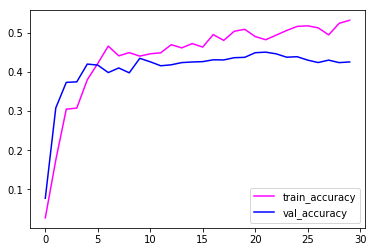

Model saved
test score: 0.50 


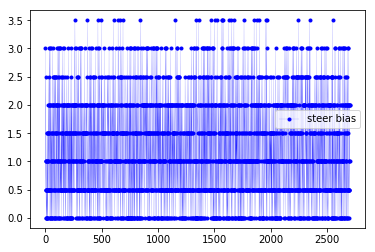

0.49784835965024199

In [89]:
model_all,test_img, test_y = train_model(range(1, 2),  tesla_model, res_w, res_h, ifSave = True)
test_model(model_all, test_img, test_y, ifShow = True, note = "test")

In [ ]:
h1,增加r2w=0.00003, r2b=0.00003，drop

/home/ubuntu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(3, (5, 5), padding="same", activation="relu", kernel_initializer="he_normal", strides=(2, 2))`
  
/home/ubuntu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), padding="same", activation="relu", kernel_initializer="he_normal", strides=(2, 2))`
  # Remove the CWD from sys.path while we load stuff.
/home/ubuntu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), padding="same", activation="relu", kernel_initializer="he_normal", strides=(2, 2))`
  if sys.path[0] == '':
/home/ubuntu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(84, (5, 5), padding="same", activation="relu", kernel_initial

Epoch 1/1
24/24 [==============================] - 7s 290ms/step - loss: 10.7925
Epoch 1/1
61/61 [==============================] - 4s 68ms/step - loss: 3.7822
Epoch 1/1
43/43 [==============================] - 3s 67ms/step - loss: 6.9606
Epoch 1/1
43/43 [==============================] - 3s 67ms/step - loss: 48.3327
Epoch 1/1
43/43 [==============================] - 3s 67ms/step - loss: 9.6053
Epoch 1/1
43/43 [==============================] - 3s 67ms/step - loss: 18.5408
Epoch 1/1
43/43 [==============================] - 3s 67ms/step - loss: 9.6215
Epoch 1/1
43/43 [==============================] - 3s 67ms/step - loss: 1.7234: 0s - loss: 
train score: -0.14 
val score: 0.05 
Epoch 1/1
24/24 [==============================] - 2s 67ms/step - loss: 6.1678
Epoch 1/1
61/61 [==============================] - 4s 68ms/step - loss: 1.8844
Epoch 1/1
43/43 [==============================] - 3s 67ms/step - loss: 3.6390
Epoch 1/1
43/43 [==============================] - 3s 67ms/step - loss: 12.49

43/43 [==============================] - 3s 67ms/step - loss: 0.3333
Epoch 1/1
43/43 [==============================] - 3s 67ms/step - loss: 0.7118
Epoch 1/1
43/43 [==============================] - 3s 67ms/step - loss: 0.4361
Epoch 1/1
43/43 [==============================] - 3s 67ms/step - loss: 0.4749
Epoch 1/1
43/43 [==============================] - 3s 67ms/step - loss: 0.4366
Epoch 1/1
43/43 [==============================] - 3s 67ms/step - loss: 0.1969
train score: 0.51 
val score: 0.35 
Epoch 1/1
24/24 [==============================] - 2s 67ms/step - loss: 0.2429
Epoch 1/1
61/61 [==============================] - 4s 68ms/step - loss: 0.1799
Epoch 1/1
43/43 [==============================] - 3s 67ms/step - loss: 0.3437
Epoch 1/1
43/43 [==============================] - 3s 67ms/step - loss: 0.6995
Epoch 1/1
43/43 [==============================] - 3s 67ms/step - loss: 0.4317
Epoch 1/1
43/43 [==============================] - 3s 67ms/step - loss: 0.4387
Epoch 1/1
43/43 [=========

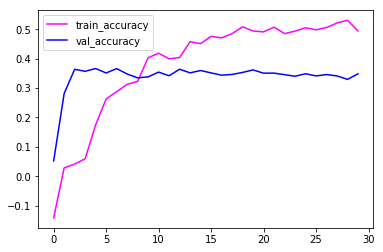

Model saved
test score: 0.49 


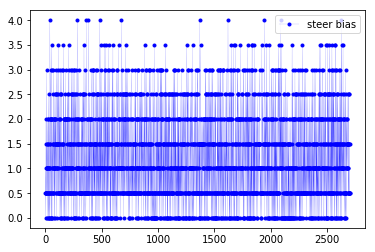

0.48631733383055775

In [83]:
model_all,test_img, test_y = train_model(range(1, 2),  tesla_model, res_w, res_h, ifSave = True)
test_model(model_all, test_img, test_y, ifShow = True, note = "test")

In [ ]:
增加conv_6_1 1*1 con5_1 1*1

/home/ubuntu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(3, (5, 5), padding="same", activation="relu", kernel_initializer="he_normal", strides=(2, 2))`
  
/home/ubuntu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), padding="same", activation="relu", kernel_initializer="he_normal", strides=(2, 2))`
  # Remove the CWD from sys.path while we load stuff.
/home/ubuntu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), padding="same", activation="relu", kernel_initializer="he_normal", strides=(2, 2))`
  if sys.path[0] == '':
/home/ubuntu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(84, (5, 5), padding="same", activation="relu", kernel_initial

Epoch 1/1
24/24 [==============================] - 5s 212ms/step - loss: 11.1794
Epoch 1/1
61/61 [==============================] - 4s 64ms/step - loss: 3.8830
Epoch 1/1
43/43 [==============================] - 3s 62ms/step - loss: 7.4311
Epoch 1/1
43/43 [==============================] - 3s 62ms/step - loss: 48.6152
Epoch 1/1
43/43 [==============================] - 3s 62ms/step - loss: 6.1953
Epoch 1/1
43/43 [==============================] - 3s 62ms/step - loss: 19.4650
Epoch 1/1
43/43 [==============================] - 3s 62ms/step - loss: 8.7334
Epoch 1/1
43/43 [==============================] - 3s 62ms/step - loss: 1.2156
train score: -0.01 
val score: 0.22 
Epoch 1/1
24/24 [==============================] - 1s 62ms/step - loss: 4.5785
Epoch 1/1
61/61 [==============================] - 4s 63ms/step - loss: 1.3316
Epoch 1/1
43/43 [==============================] - 3s 62ms/step - loss: 3.2924
Epoch 1/1
43/43 [==============================] - 3s 63ms/step - loss: 9.1645
Epoch 1/1
4

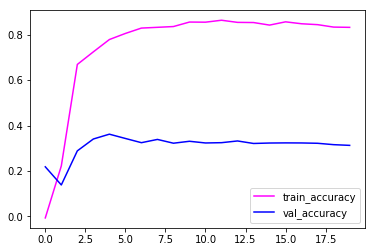

Model saved
test score: 0.51 


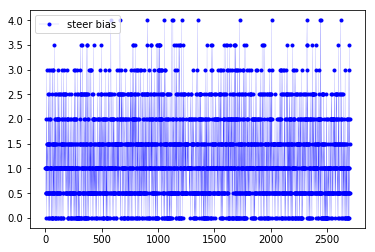

0.50533125938429224

In [69]:
model_all,test_img, test_y = train_model(range(1, 2),  tesla_model, res_w, res_h, ifSave = True)
test_model(model_all, test_img, test_y, ifShow = True, note = "test")

In [ ]:
加深网络，添加con_5 5*5, con_6 3*3

/home/ubuntu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(3, (5, 5), padding="same", activation="relu", kernel_initializer="he_normal", strides=(2, 2))`
  
/home/ubuntu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), padding="same", activation="relu", kernel_initializer="he_normal", strides=(2, 2))`
  # Remove the CWD from sys.path while we load stuff.
/home/ubuntu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), padding="same", activation="relu", kernel_initializer="he_normal", strides=(2, 2))`
  if sys.path[0] == '':
/home/ubuntu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(84, (5, 5), padding="same", activation="relu", kernel_initial

Epoch 1/1
24/24 [==============================] - 4s 164ms/step - loss: 11.1813
Epoch 1/1
61/61 [==============================] - 3s 57ms/step - loss: 3.8353
Epoch 1/1
43/43 [==============================] - 2s 56ms/step - loss: 7.2348
Epoch 1/1
43/43 [==============================] - 2s 56ms/step - loss: 51.0157
Epoch 1/1
43/43 [==============================] - 2s 55ms/step - loss: 7.3105
Epoch 1/1
43/43 [==============================] - 2s 56ms/step - loss: 17.3914
Epoch 1/1
43/43 [==============================] - 2s 56ms/step - loss: 6.3781
Epoch 1/1
43/43 [==============================] - 2s 56ms/step - loss: 1.5550
train score: -0.21 
val score: 0.24 
Epoch 1/1
24/24 [==============================] - 1s 55ms/step - loss: 4.1851
Epoch 1/1
61/61 [==============================] - 3s 56ms/step - loss: 1.1994
Epoch 1/1
43/43 [==============================] - 2s 56ms/step - loss: 3.7742
Epoch 1/1
43/43 [==============================] - 2s 55ms/step - loss: 10.2104
Epoch 1/1


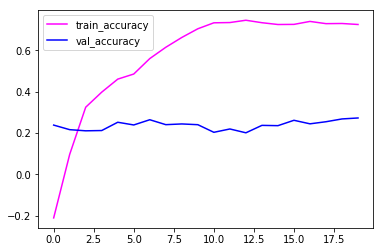

Model saved
test score: 0.30 


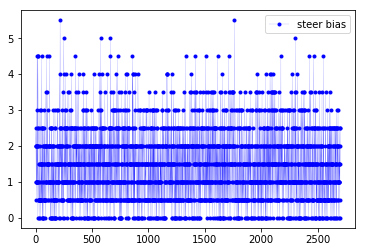

0.30194359120305403

In [57]:
model_all,test_img, test_y = train_model(range(1, 2),  tesla_model, res_w, res_h, ifSave = True)
test_model(model_all, test_img, test_y, ifShow = True, note = "test")

In [ ]:
加深网络，添加con_5 5*5

/home/ubuntu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(3, (5, 5), padding="same", activation="relu", kernel_initializer="he_normal", strides=(2, 2))`
  
/home/ubuntu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), padding="same", activation="relu", kernel_initializer="he_normal", strides=(2, 2))`
  # Remove the CWD from sys.path while we load stuff.
/home/ubuntu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), padding="same", activation="relu", kernel_initializer="he_normal", strides=(2, 2))`
  if sys.path[0] == '':


Epoch 1/1
24/24 [==============================] - 4s 168ms/step - loss: 8.8213
Epoch 1/1
61/61 [==============================] - 4s 69ms/step - loss: 1.6476
Epoch 1/1
43/43 [==============================] - 3s 68ms/step - loss: 5.8338
Epoch 1/1
43/43 [==============================] - 3s 67ms/step - loss: 26.5199
Epoch 1/1
43/43 [==============================] - 3s 68ms/step - loss: 5.4593
Epoch 1/1
43/43 [==============================] - 3s 67ms/step - loss: 10.2694
Epoch 1/1
43/43 [==============================] - 3s 67ms/step - loss: 5.2921
Epoch 1/1
43/43 [==============================] - 3s 67ms/step - loss: 1.3527
train score: -0.20 
val score: 0.22 
Epoch 1/1
24/24 [==============================] - 2s 67ms/step - loss: 3.4308: 0s - loss: 3.67
Epoch 1/1
61/61 [==============================] - 4s 68ms/step - loss: 0.8227
Epoch 1/1
43/43 [==============================] - 3s 68ms/step - loss: 2.8324
Epoch 1/1
43/43 [==============================] - 3s 68ms/step - loss: 5.

24/24 [==============================] - 2s 67ms/step - loss: 0.0658
Epoch 1/1
61/61 [==============================] - 4s 68ms/step - loss: 0.0513
Epoch 1/1
43/43 [==============================] - 3s 67ms/step - loss: 0.1079
Epoch 1/1
43/43 [==============================] - 3s 68ms/step - loss: 0.1210
Epoch 1/1
43/43 [==============================] - 3s 68ms/step - loss: 0.1876
Epoch 1/1
43/43 [==============================] - 3s 67ms/step - loss: 0.0976
Epoch 1/1
43/43 [==============================] - 3s 68ms/step - loss: 0.1168
Epoch 1/1
43/43 [==============================] - 3s 67ms/step - loss: 0.0383
train score: 0.56 
val score: 0.37 
Epoch 1/1
24/24 [==============================] - 2s 67ms/step - loss: 0.0550
Epoch 1/1
61/61 [==============================] - 4s 69ms/step - loss: 0.0441
Epoch 1/1
43/43 [==============================] - 3s 68ms/step - loss: 0.0953
Epoch 1/1
43/43 [==============================] - 3s 68ms/step - loss: 0.1195
Epoch 1/1
43/43 [=========

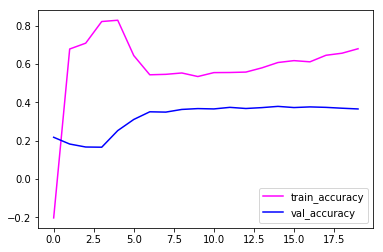

Model saved
test score: 0.43 


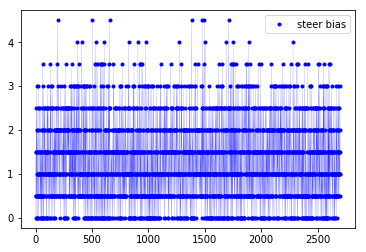

0.42663814168931979

In [55]:
model_all,test_img, test_y = train_model(range(1, 2),  tesla_model, res_w, res_h, ifSave = True)
test_model(model_all, test_img, test_y, ifShow = True, note = "test")

In [ ]:
训练简单网络，去掉全部Bn

/home/ubuntu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(3, (5, 5), padding="same", activation="relu", kernel_initializer="he_normal", strides=(2, 2))`
  
/home/ubuntu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), padding="same", activation="relu", kernel_initializer="he_normal", strides=(2, 2))`
  # Remove the CWD from sys.path while we load stuff.
/home/ubuntu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), padding="same", activation="relu", kernel_initializer="he_normal", strides=(2, 2))`
  if sys.path[0] == '':


Epoch 1/1
24/24 [==============================] - 3s 120ms/step - loss: 10.9768
Epoch 1/1
61/61 [==============================] - 3s 46ms/step - loss: 3.6957
Epoch 1/1
43/43 [==============================] - 2s 45ms/step - loss: 7.1710
Epoch 1/1
43/43 [==============================] - 2s 45ms/step - loss: 51.7199
Epoch 1/1
43/43 [==============================] - 2s 46ms/step - loss: 14.2792
Epoch 1/1
43/43 [==============================] - 2s 45ms/step - loss: 32.5985
Epoch 1/1
43/43 [==============================] - 2s 46ms/step - loss: 24.0300
Epoch 1/1
43/43 [==============================] - 2s 45ms/step - loss: 2.7936
train score: -0.07 
val score: -0.03 
Epoch 1/1
24/24 [==============================] - 1s 45ms/step - loss: 11.2737
Epoch 1/1
61/61 [==============================] - 3s 46ms/step - loss: 3.8803
Epoch 1/1
43/43 [==============================] - 2s 45ms/step - loss: 7.6922
Epoch 1/1
43/43 [==============================] - 2s 45ms/step - loss: 70.8805
Epoch 

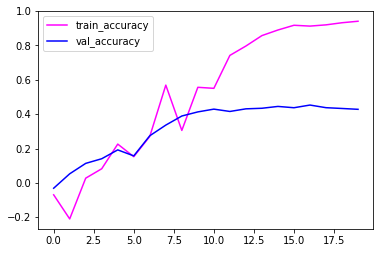

Model saved
test score: 0.04 


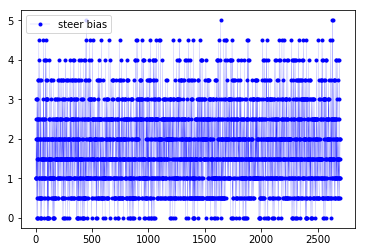

0.041677707010536524

In [49]:
model_all,test_img, test_y = train_model(range(1, 2),  tesla_model, res_w, res_h, ifSave = True)
test_model(model_all, test_img, test_y, ifShow = True, note = "test")

In [ ]:
训练简单网络，使用基本网络，只增加Bn。

/home/ubuntu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(3, (5, 5), padding="same", activation="relu", kernel_initializer="he_normal", strides=(2, 2))`
  
/home/ubuntu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), padding="same", activation="relu", kernel_initializer="he_normal", strides=(2, 2))`
  # Remove the CWD from sys.path while we load stuff.
/home/ubuntu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), padding="same", activation="relu", kernel_initializer="he_normal", strides=(2, 2))`
  if sys.path[0] == '':


Epoch 1/1
24/24 [==============================] - 3s 138ms/step - loss: 9.5858
Epoch 1/1
61/61 [==============================] - 3s 54ms/step - loss: 1.1757
Epoch 1/1
43/43 [==============================] - 2s 54ms/step - loss: 4.0978
Epoch 1/1
43/43 [==============================] - 2s 54ms/step - loss: 16.9110
Epoch 1/1
43/43 [==============================] - 2s 54ms/step - loss: 7.3983
Epoch 1/1
43/43 [==============================] - 2s 54ms/step - loss: 15.1969
Epoch 1/1
43/43 [==============================] - 2s 54ms/step - loss: 7.0352
Epoch 1/1
43/43 [==============================] - 2s 54ms/step - loss: 1.5316
train score: -0.34 
val score: 0.28 
Epoch 1/1
24/24 [==============================] - 1s 53ms/step - loss: 5.0806
Epoch 1/1
61/61 [==============================] - 3s 55ms/step - loss: 0.9236
Epoch 1/1
43/43 [==============================] - 2s 54ms/step - loss: 2.7914
Epoch 1/1
43/43 [==============================] - 2s 54ms/step - loss: 5.9145
Epoch 1/1
43

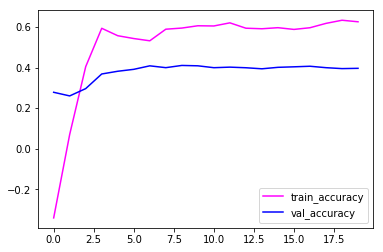

Model saved
test score: 0.36 


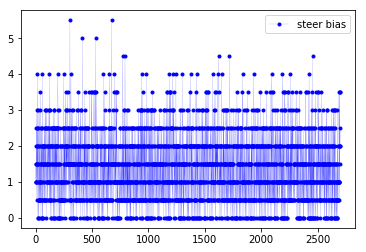

0.36399441276819855

In [51]:

model_all,test_img, test_y = train_model(range(1, 2),  tesla_model, res_w, res_h, ifSave = True)
test_model(model_all, test_img, test_y, ifShow = True, note = "test")

In [ ]:
使用多个模型共同预测

In [ ]:
from keras.models import *
from keras.layers import *
from keras.applications import *
from keras.preprocessing.image import *
import h5py

        
def write_gap(MODEL, image_size, lambda_func=None):
    width = image_size[0]
    height = image_size[1]
    input_tensor = Input((height, width, 3))
    x = input_tensor
    if lambda_func:
        x = Lambda(lambda_func)(x)
    
    base_model = MODEL(input_tensor=x, weights='imagenet', include_top=False)
    model = Model(base_model.input, GlobalAveragePooling2D()(base_model.output))
    
    ######
    for video_idx in range(1, 10):
        x_train, y_train = load_preprocess_training_batch(video_idx, image_size[0], image_size[1])
        print (image_size[0])
        x_train = np.array(x_train).transpose(model_trans)
         #   print(model_trans)
            #随机打乱数据，取10%的训练数据做验证集
        img_list_train, img_list_val, steer_list_train, steer_list_val = train_test_split(x_train, np.array(y_train), test_size=0.1, random_state=10) 
        
        gen = ImageDataGenerator()
        gen.fit(img_list_train)
        train_generator = gen.flow(img_list_train, steer_list_train, batch_size=batch_size)
        train = model.predict_generator(train_generator, train_generator.nb_sample)
        with h5py.File("train_%s_epoch{:0>2}.h5"%MODEL.func_name,video_idx) as h:  
            h.create_dataset("train", data=train)
            h.create_dataset("y", data=steer_list_train)
        
        if x_val.shape == np.array([]).shape:
            x_val = img_list_val
            y_val = list(steer_list_val)
        else:
            x_val = np.vstack((x_val, img_list_val))
            y_val.extend(list(steer_list_val))
    #####
    gen_val = ImageDataGenerator()
    train_generator = gen.flow_from_directory("train2", image_size, shuffle=False, 
                                              batch_size=16)
    test_generator = gen.flow_from_directory("test2", image_size, shuffle=False, 
                                             batch_size=16, class_mode=None)
    train = model.predict_generator(train_generator, train_generator.nb_sample)
    test = model.predict_generator(test_generator, test_generator.nb_sample)
    with h5py.File("gap_%s.h5"%MODEL.func_name) as h:
        h.create_dataset("train", data=train)
        h.create_dataset("test", data=test)
        h.create_dataset("label", data=train_generator.classes)

write_gap(ResNet50, (224, 224))
write_gap(InceptionV3, (299, 299), inception_v3.preprocess_input)
write_gap(Xception, (299, 299), xception.preprocess_input)

In [ ]:
训练inceptionV3算法模型，修改的参数一个是学习率，另一个是算法从哪个层开始训练，之前的权重保留，但是测试集上的准确率都不好，
稍微上升了然后就不增或者慢慢下降了，最多到了0.5.

0 input_4
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_pool
11 block4_conv1
12 block4_conv2
13 block4_conv3
14 block4_pool
15 block5_conv1
16 block5_conv2
17 block5_conv3
18 block5_pool
Epoch 1/1
47/47 [==============================] - 83s 2s/step - loss: 41.5234
Epoch 1/1
122/122 [==============================] - 211s 2s/step - loss: 4.1443
Epoch 1/1
85/85 [==============================] - 146s 2s/step - loss: 7.7690
Epoch 1/1
85/85 [==============================] - 146s 2s/step - loss: 73.0880
Epoch 1/1
85/85 [==============================] - 146s 2s/step - loss: 24.4887
Epoch 1/1
85/85 [==============================] - 149s 2s/step - loss: 44.5777
Epoch 1/1
85/85 [==============================] - 151s 2s/step - loss: 22.2482
Epoch 1/1
85/85 [==============================] - 151s 2s/step - loss: 1.6993
train score: -0.79 
val score: 0.25 
Epoch 1/1
47/47 [========================

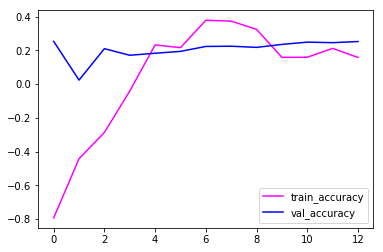

Model saved
test score: 0.17 


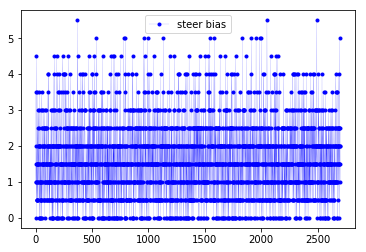

0.17275112284386185

In [26]:
vgg_start_train_net = 0
vgg_r_w = 0
vgg_r_b = 0
vgg_lr = 0.00005
model_all , test_img, test_y= train_model(range(1, 2),  vgg19_model, res_w, res_h, ifSave = True)
test_model(model_all, test_img, test_y, ifShow = True, note = "test")
#test_model(model_all, x_test, y_test)

In [ ]:
修改lr = 0.0005

In [30]:
vgg_start_train_net = 0
vgg_r_w = 0
vgg_r_b = 0
vgg_lr = 0.0005
model_all , test_img, test_y= train_model(range(1, 2),  vgg19_model, res_w, res_h, ifSave = True)
test_model(model_all, test_img, test_y, ifShow = True, note = "test")

0 input_8
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_pool
11 block4_conv1
12 block4_conv2
13 block4_conv3
14 block4_pool
15 block5_conv1
16 block5_conv2
17 block5_conv3
18 block5_pool
Epoch 1/1
 4/47 [=>............................] - ETA: 1:39 - loss: 6130319033823263.0000

KeyboardInterrupt: 

In [ ]:
修改lr = 0.000005

0 input_9
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_pool
11 block4_conv1
12 block4_conv2
13 block4_conv3
14 block4_pool
15 block5_conv1
16 block5_conv2
17 block5_conv3
18 block5_pool
Epoch 1/1
47/47 [==============================] - 87s 2s/step - loss: 6.7256
Epoch 1/1
122/122 [==============================] - 221s 2s/step - loss: 2.9238
Epoch 1/1
85/85 [==============================] - 153s 2s/step - loss: 4.4283
Epoch 1/1
85/85 [==============================] - 153s 2s/step - loss: 6.9954
Epoch 1/1
85/85 [==============================] - 153s 2s/step - loss: 4.9015
Epoch 1/1
85/85 [==============================] - 153s 2s/step - loss: 5.6218
Epoch 1/1
85/85 [==============================] - 153s 2s/step - loss: 4.8393
Epoch 1/1
85/85 [==============================] - 153s 2s/step - loss: 1.9269
train score: 0.47 
val score: 0.32 
Epoch 1/1
47/47 [==============================

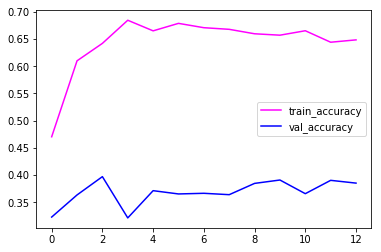

Model saved
test score: -0.10 


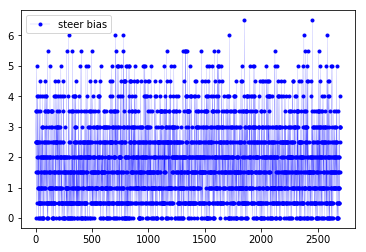

-0.097021724125522901

In [ ]:
vgg_start_train_net = 0
vgg_r_w = 0
vgg_r_b = 0
vgg_lr = 0.000005
model_all , test_img, test_y= train_model(range(1, 2),  vgg19_model, res_w, res_h, ifSave = True)
test_model(model_all, test_img, test_y, ifShow = True, note = "test")

In [ ]:
lr = 0.00005,修改start=7

In [ ]:
vgg_start_train_net = 7
vgg_r_w = 0
vgg_r_b = 0
vgg_lr = 0.00005
model_all , test_img, test_y= train_model(range(1, 2),  vgg19_model, res_w, res_h, ifSave = True)
test_model(model_all, test_img, test_y, ifShow = True, note = "test")

In [ ]:
lr = 0.00005,修改start=11

In [ ]:
vgg_start_train_net = 11
vgg_r_w = 0
vgg_r_b = 0
vgg_lr = 0.00005
model_all , test_img, test_y= train_model(range(1, 2),  vgg19_model, res_w, res_h, ifSave = True)
test_model(model_all, test_img, test_y, ifShow = True, note = "test")

In [ ]:
lr = 0.00005,修改start=15

In [ ]:
vgg_start_train_net = 15
vgg_r_w = 0
vgg_r_b = 0
vgg_lr = 0.00005
model_all , test_img, test_y= train_model(range(1, 2),  vgg19_model, res_w, res_h, ifSave = True)
test_model(model_all, test_img, test_y, ifShow = True, note = "test")

In [ ]:
lr = 0.00005,修改start=15

0 input_11
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_pool
11 block4_conv1
12 block4_conv2
13 block4_conv3
14 block4_pool
15 block5_conv1
16 block5_conv2
17 block5_conv3
18 block5_pool
Epoch 1/1
47/47 [==============================] - 29s 617ms/step - loss: 676.8177
Epoch 1/1
122/122 [==============================] - 70s 572ms/step - loss: 1.2250
Epoch 1/1
85/85 [==============================] - 48s 570ms/step - loss: 2.6474
Epoch 1/1
85/85 [==============================] - 48s 570ms/step - loss: 5.5081
Epoch 1/1
85/85 [==============================] - 48s 570ms/step - loss: 3.8187
Epoch 1/1
85/85 [==============================] - 48s 570ms/step - loss: 4.9587
Epoch 1/1
85/85 [==============================] - 48s 570ms/step - loss: 4.2742
Epoch 1/1
85/85 [==============================] - 48s 570ms/step - loss: 1.0246
train score: 0.63 
val score: 0.51 
Epoch 1/1
47/47 [==========

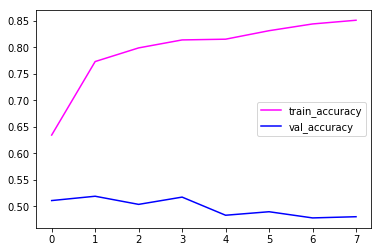

Model saved
test score: 0.20 


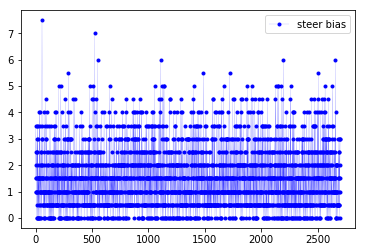

0.20251916113013868

In [34]:
vgg_start_train_net = 19
vgg_r_w = 0
vgg_r_b = 0
vgg_lr = 0.00005
model_all , test_img, test_y= train_model(range(1, 2),  vgg19_model, res_w, res_h, ifSave = True)
test_model(model_all, test_img, test_y, ifShow = True, note = "test")

In [ ]:
lr = 0.00005, start = 0,修改l2

In [ ]:
vgg_start_train_net = 0
vgg_r_w = 0.003
vgg_r_b = 0.003
vgg_lr = 0.00005
model_all , test_img, test_y= train_model(range(1, 2),  vgg19_model, res_w, res_h, ifSave = True)
test_model(model_all, test_img, test_y, ifShow = True, note = "test")

In [ ]:
lr = 0.00005, start = 0,修改l2

In [ ]:
vgg_start_train_net = 0
vgg_r_w = 0.005
vgg_r_b = 0.003
vgg_lr = 0.00005
model_all , test_img, test_y= train_model(range(1, 2),  vgg19_model, res_w, res_h, ifSave = True)
test_model(model_all, test_img, test_y, ifShow = True, note = "test")

In [ ]:
lr = 0.00005, start = 0,修改l2

In [ ]:
vgg_start_train_net = 0
vgg_r_w = 0.005
vgg_r_b = 0.005
vgg_lr = 0.00005
model_all , test_img, test_y= train_model(range(1, 2),  vgg19_model, res_w, res_h, ifSave = True)
test_model(model_all, test_img, test_y, ifShow = True, note = "test")

实验了一下办监督学习，结果也不好

In [47]:
def inception_v3_semi_super_model():
    base_model = InceptionV3(weights='imagenet', include_top=True)
    model = Model(input=base_model.input, output=base_model.get_layer('avg_pool').output)
    return model

In [53]:
def get_featurn_h5_path(video_idx):
    return utils.join_dir(params.data_dir, 'epoch{:0>2}_feature.h5').format(video_idx)
def get_y_h5_path(video_idx):
    return utils.join_dir(params.data_dir, 'epoch{:0>2}_y.h5').format(video_idx)
def save_feature_and_y_h5(model, video_list):
    for v_idx in video_list:
        features = []
        x_test, y_test = load_preprocess_training_batch(v_idx, res_w, res_h)   
        x_test = np.array(x_test).transpose(model_trans)
        for x in x_test:            
            x = np.expand_dims(x, axis=0)
          #  print (x)
         #   x = preprocess_input(x)
         #   x /= 127.5
         #   x -= 1.
            feature = model.predict(x)
            flat = feature.flatten()
            if v_idx== 1:
                print(flat)
            features.append(flat)
            
        vid_path = utils.join_dir(params.data_dir, 'epoch{:0>2}_feature.h5').format(v_idx)
        y_path = utils.join_dir(params.data_dir, 'epoch{:0>2}_y.h5').format(v_idx)

        h5f_data = h5py.File(vid_path, 'w')
        h5f_data.create_dataset('dataset_1', data=np.array(features))
        h5f_data.close()
        
        h5y_data = h5py.File(y_path, 'w')
        h5y_data.create_dataset('dataset_1', data=np.array(y_test))
        h5y_data.close()
        print(vid_path)
        
def get_feature_and_y(video_idx):
    h5f_data  = h5py.File(get_featurn_h5_path(video_idx), 'r')
    h5f_y = h5py.File(get_y_h5_path(video_idx), 'r')

    features = h5f_data['dataset_1']
    ys = h5f_y['dataset_1']

    features = np.array(features)
    ys   = np.array(ys)

    h5f_data.close()
    h5f_y.close()
    return features, ys

In [102]:
import h5py
import pandas as pd
from sklearn.model_selection import KFold 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer


from sklearn import tree
def performance_metric(y_true, y_predict):
    
    score = r2_score(y_true, y_predict)

    return score
def train_semi_super_model(video_list, cnn_model_func, resize_w, resize_h, ifSave = False, test_video=None, if_save_feature=True):
    cnn_model = cnn_model_func()
    if if_save_feature == True:
        save_feature_and_y_h5(cnn_model, video_list)
        if test_video != None:
            save_feature_and_y_h5(cnn_model, [test_video])
    
    val_acc = []
    test_acc = []
    
    
    x_train = np.array([])
    y_train = []
    x_val = np.array([])
    y_val = []
    print("start load h5")
    for video_idx in range(1, len(video_list) + 1):
            
        features, ys = get_feature_and_y(video_idx)
            
        #随机打乱数据，取10%的训练数据做验证集
        f_list_train, f_list_val, steer_list_train, steer_list_val = train_test_split(features, np.array(ys), test_size=0.1, random_state=10) 
            
        if x_val.shape == np.array([]).shape:
            x_train = f_list_train
            y_train = list(steer_list_train)
            x_val = f_list_val
            y_val = list(steer_list_val)
        else:
            x_train = np.vstack((x_train, f_list_train))
            y_train.extend(list(steer_list_train))
            x_val = np.vstack((x_val, f_list_val))
            y_val.extend(list(steer_list_val))
        print(len(y_val))
        
    cross_validator = KFold(n_splits=10)
    regressor = tree.DecisionTreeRegressor()
    params = {'max_depth':[100,200,300,400,500,600,700,800,900,10000]}
    grid =  GridSearchCV(regressor,param_grid=params,scoring=make_scorer(performance_metric), cv=cross_validator)

    grid.fit(f_list_train, steer_list_train)
    print (pd.DataFrame(grid.cv_results_))

  #  val_acc.append(test_model(grid.best_estimator_, x_val, y_val))
    if test_video != None:
        test_features, test_ys = get_feature_and_y(test_video)
        test_acc.append(test_model(grid.best_estimator_, test_features, test_ys))
  #  if ifSave == True:
      #  utils.save_model(regressor)
        
 #   plt.plot(val_acc,color='b', label='验证准确率')
  #  plt.plot(test_acc, color='g', label='测试准确率')
 #   plt.show()
 #   return model

/Users/apple/.keras/models/inception_v3_weights_tf_dim_ordering_tf_kernels.h5


/anaconda3/envs/dlnd-tf-lab/lib/python3.5/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("av...)`
  This is separate from the ipykernel package so we can avoid doing imports until


start load h5
150
540
810
1080
1350
1620
1890
2160
2430
   mean_fit_time  mean_score_time  mean_test_score  mean_train_score  \
0       5.655519         0.007093         0.811431               1.0   
1       5.516026         0.001803         0.798067               1.0   
2       5.503612         0.000903         0.822081               1.0   
3       5.444082         0.000887         0.804631               1.0   
4       5.470009         0.000802         0.803466               1.0   
5       5.547984         0.000866         0.823357               1.0   
6       5.452721         0.000827         0.797042               1.0   
7       5.452158         0.000915         0.809544               1.0   
8       5.485898         0.000906         0.812880               1.0   
9       5.451528         0.000904         0.811314               1.0   

  param_max_depth                params  rank_test_score  split0_test_score  \
0             100    {'max_depth': 100}                4           0.824

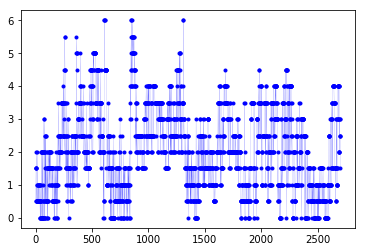

In [103]:
train_semi_super_model(range(1, 10),  inception_v3_semi_super_model, res_w, res_h, ifSave = True, test_video = 10,if_save_feature=False)
